<a href="https://colab.research.google.com/github/yoandym/colab/blob/main/macd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install yfinance
!pip install mplfinance


In [24]:
# Download data
from datetime import datetime
import yfinance as yf

start_date = datetime(2021, 5, 5)
end_date = datetime(2021, 5, 6)
data = yf.download(tickers='EURUSD=X', start=start_date, end=end_date, interval="1m")


[*********************100%***********************]  1 of 1 completed


In [18]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-05-03 00:00:00+01:00,1.203080,1.203080,1.203080,1.203080,1.203080,0
2021-05-03 00:01:00+01:00,1.203514,1.203514,1.203514,1.203514,1.203514,0
2021-05-03 00:02:00+01:00,1.203369,1.203369,1.203369,1.203369,1.203369,0
2021-05-03 00:03:00+01:00,1.203225,1.203225,1.203225,1.203225,1.203225,0
2021-05-03 00:04:00+01:00,1.203225,1.203225,1.203225,1.203225,1.203225,0


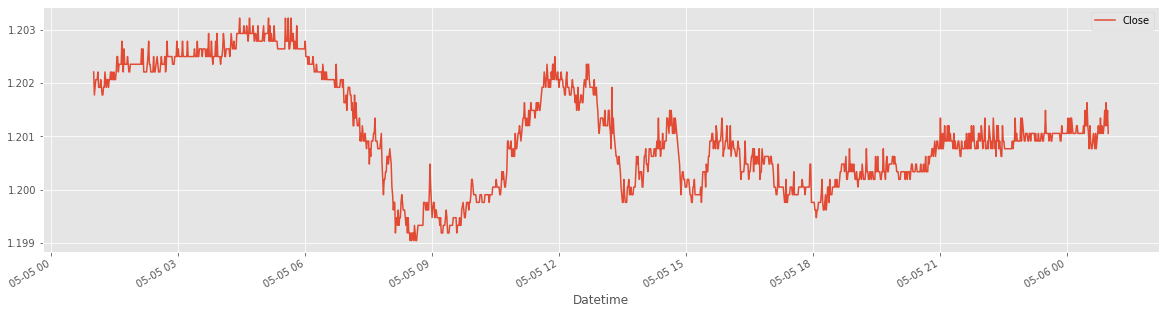

In [25]:
import pandas as pd

# Import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Read the data
data.index = pd.to_datetime(data.index, dayfirst=True)

# Visualise the data
plt.figure(figsize=(20,5))
data['Close'].plot(figsize=(20,5))
plt.legend()
plt.show()

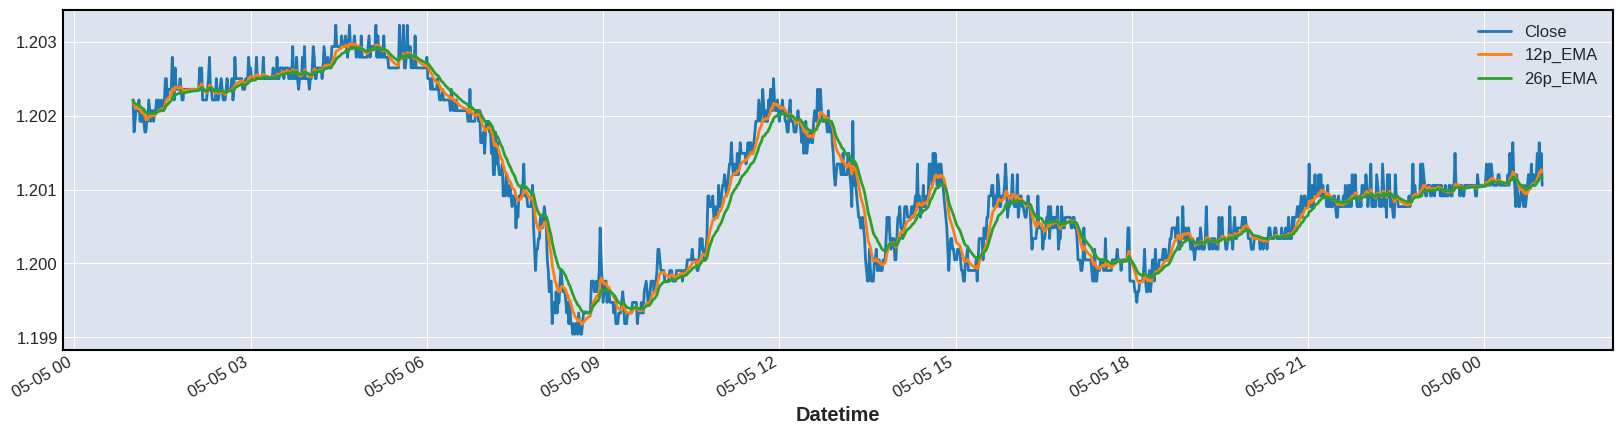

In [36]:
# Calculate exponential moving average
data['12p_EMA'] = data.Close.ewm(span=12, adjust=False).mean()
data['26p_EMA'] = data.Close.ewm(span=26, adjust=False).mean()

data[['Close','12p_EMA','26p_EMA']].plot(figsize=(20,5))
plt.show()



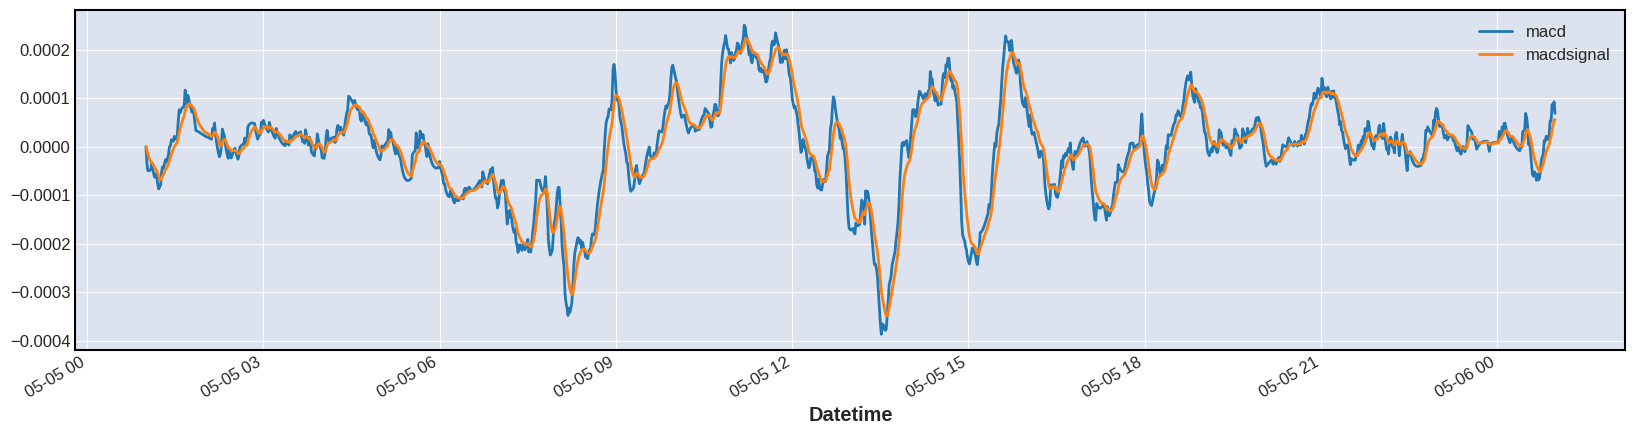

In [37]:
# Calculate MACD
data['macd'] = data['12p_EMA']- data['26p_EMA'] 

# Calculate Signal
data['macdsignal'] = data.macd.ewm(span=9, adjust=False).mean()

data[['macd','macdsignal']].plot(figsize=(20,5))
plt.show()

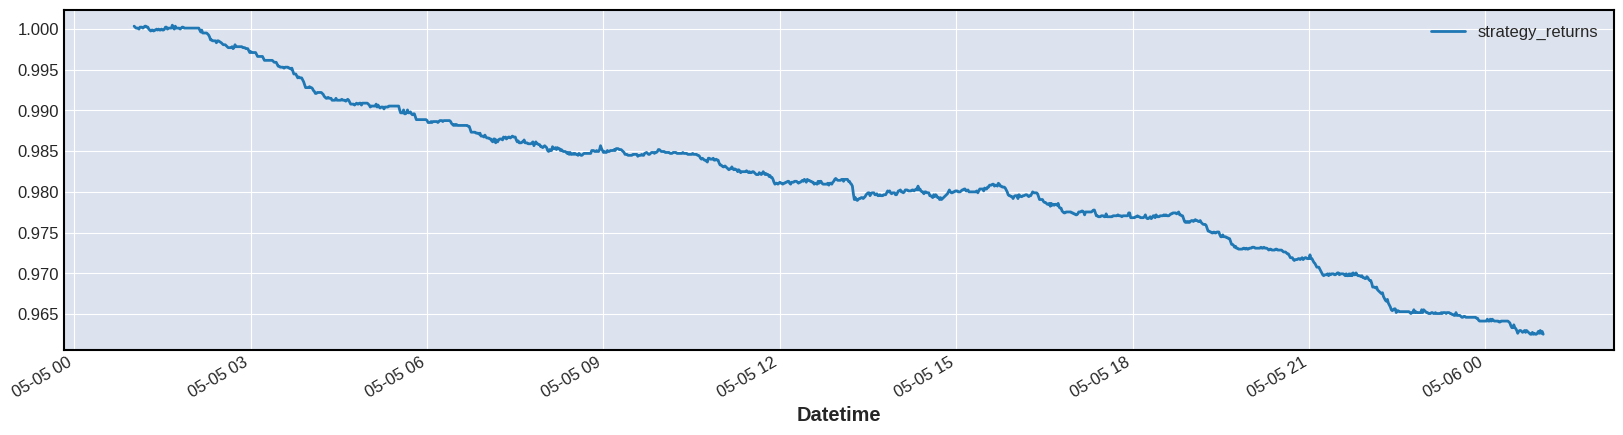

In [40]:
# Import numpy
import numpy as np

# Define Signal
data['trading_signal'] = np.where(data['macd'] > data['macdsignal'], 1, -1)

# Calculate Returns
data['returns'] = data.Close.pct_change()

# Calculate Strategy Returns
data['strategy_returns'] = data.returns * data.trading_signal.shift(1)

# Calculate Cumulative Returns
cumulative_strategy_returns = (data.strategy_returns + 1).cumprod()

# Plot Strategy Returns
cumulative_strategy_returns.plot(figsize=(20,5))
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:45: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)
/usr/local/lib/python3.7/dist-packages/mplfinance/plotting.py:535: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)


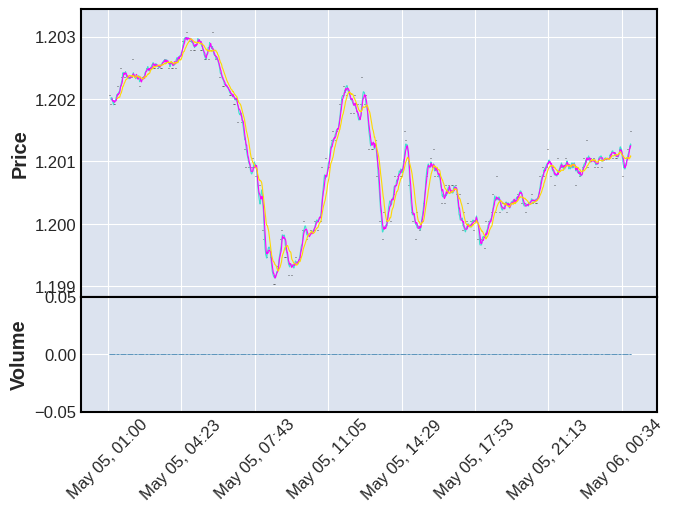

In [32]:
import mplfinance as mpf

mpf.plot(data,type='candle',mav=(9,12,26),volume=True)